In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
import logging
import sys
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import Xception, MobileNetV2, EfficientNetB7
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import json


In [28]:
df = pd.read_csv('/Users/priyankapalaniselvam/Downloads/RetinaNet/concatenated dataset.csv')
print(df.head())
print(df.value_counts().sum())

                                image_path     label    source
0     cataract_data/cataract/2124_left.jpg  Cataract  cataract
1   cataract_data/cataract/_393_746807.jpg  Cataract  cataract
2     cataract_data/cataract/2125_left.jpg  Cataract  cataract
3  cataract_data/cataract/_182_9646286.jpg  Cataract  cataract
4   cataract_data/cataract/_245_498355.jpg  Cataract  cataract
37870


In [29]:
print(df['label'].unique())
print(df['label'].value_counts().unique())

['Cataract' 'Normal' 'Mild DR' 'Moderate DR' 'Proliferative DR'
 'Severe DR' 'Glaucoma']
[27358  5288  2438  1038   872   708   168]


In [30]:
df['label'].value_counts()

label
Normal              27358
Moderate DR          5288
Mild DR              2438
Cataract             1038
Severe DR             872
Proliferative DR      708
Glaucoma              168
Name: count, dtype: int64

In [32]:
def map_labels(df):
    df['cataract_label'] = df['label'].apply(lambda x: 1 if x == 'Cataract' else 0)
    df['glaucoma_label'] = df['label'].apply(lambda x: 1 if x == 'Glaucoma' else 0)
    df['dr_label'] = df['label'].apply(lambda x: 
        1 if x == 'Mild DR' else
        2 if x == 'Moderate DR' else
        3 if x == 'Severe DR' else
        4 if x == 'Proliferative DR' else
        0) 
    return df


In [33]:
df_new=map_labels(df)

In [34]:
print(df_new.tail())

                                             image_path     label    source  \
37865  glaucoma_data/archive/ORIGA/ORIGA/Images/646.jpg  Glaucoma  glaucoma   
37866  glaucoma_data/archive/ORIGA/ORIGA/Images/647.jpg  Glaucoma  glaucoma   
37867  glaucoma_data/archive/ORIGA/ORIGA/Images/648.jpg  Glaucoma  glaucoma   
37868  glaucoma_data/archive/ORIGA/ORIGA/Images/649.jpg    Normal  glaucoma   
37869  glaucoma_data/archive/ORIGA/ORIGA/Images/650.jpg  Glaucoma  glaucoma   

       cataract_label  glaucoma_label  dr_label  
37865               0               1         0  
37866               0               1         0  
37867               0               1         0  
37868               0               0         0  
37869               0               1         0  


In [35]:
X = df_new['image_path']  
a = df_new['cataract_label']  
b = df_new['glaucoma_label'] 
c = df_new['dr_label']

X_array = X.values.reshape(-1,1)
a_array = a.values.reshape(-1,1)
b_array = a.values.reshape(-1,1)
c_array = a.values.reshape(-1,1)
source = df_new['source']

In [36]:
print(len(X), len(a), len(b), len(c))

37870 37870 37870 37870


In [37]:
Temp_data = {'image_path': X,
        'cataract_label': a,
        'glaucoma_label': b,
        'dr_label':c,
        'source': source}

data = pd.DataFrame(Temp_data)


In [38]:
data.sample(10)

,image_path,cataract_label,glaucoma_label,dr_label,source
11805,DR_dataset_archive/resized_train_cropped/resiz...,0,0,0,dr
19031,DR_dataset_archive/resized_train_cropped/resiz...,0,0,3,dr
26928,DR_dataset_archive/resized_train_cropped/resiz...,0,0,2,dr
11784,DR_dataset_archive/resized_train_cropped/resiz...,0,0,0,dr
16447,DR_dataset_archive/resized_train_cropped/resiz...,0,0,2,dr
23736,DR_dataset_archive/resized_train_cropped/resiz...,0,0,0,dr
18131,DR_dataset_archive/resized_train_cropped/resiz...,0,0,0,dr
25872,DR_dataset_archive/resized_train_cropped/resiz...,0,0,0,dr
27582,DR_dataset_archive/resized_train_cropped/resiz...,0,0,3,dr
33621,DR_dataset_archive/resized_train_cropped/resiz...,0,0,0,dr


In [39]:
print(data.value_counts().sum())
print(data['dr_label'].unique())
print(data['dr_label'].value_counts().unique())
print(data['cataract_label'].unique())
print(data['cataract_label'].value_counts().unique())
print(data['glaucoma_label'].unique())
print(data['glaucoma_label'].value_counts().unique())



37870
[0 1 2 4 3]
[28564  5288  2438   872   708]
[1 0]
[36832  1038]
[0 1]
[37702   168]


In [40]:
data.loc[data['source'] == 'dr', 'image_path'] += '.jpeg'
data

,image_path,cataract_label,glaucoma_label,dr_label,source
0,cataract_data/cataract/2124_left.jpg,1,0,0,cataract
1,cataract_data/cataract/_393_746807.jpg,1,0,0,cataract
2,cataract_data/cataract/2125_left.jpg,1,0,0,cataract
3,cataract_data/cataract/_182_9646286.jpg,1,0,0,cataract
4,cataract_data/cataract/_245_498355.jpg,1,0,0,cataract
...,...,...,...,...,...
37865,glaucoma_data/archive/ORIGA/ORIGA/Images/646.jpg,0,1,0,glaucoma
37866,glaucoma_data/archive/ORIGA/ORIGA/Images/647.jpg,0,1,0,glaucoma
37867,glaucoma_data/archive/ORIGA/ORIGA/Images/648.jpg,0,1,0,glaucoma
37868,glaucoma_data/archive/ORIGA/ORIGA/Images/649.jpg,0,0,0,glaucoma


In [41]:
print(data.head())

                                image_path  cataract_label  glaucoma_label  \
0     cataract_data/cataract/2124_left.jpg               1               0   
1   cataract_data/cataract/_393_746807.jpg               1               0   
2     cataract_data/cataract/2125_left.jpg               1               0   
3  cataract_data/cataract/_182_9646286.jpg               1               0   
4   cataract_data/cataract/_245_498355.jpg               1               0   

   dr_label    source  
0         0  cataract  
1         0  cataract  
2         0  cataract  
3         0  cataract  
4         0  cataract  


In [42]:
train_data, temp_data = train_test_split(
    data, 
    test_size=0.2, 
    random_state=42
)


In [43]:
test_data, val_data = train_test_split(
    temp_data, 
    test_size=0.5, 
    random_state=42
)


In [44]:
train_datagen = ImageDataGenerator(
    rescale=1./255,                 
    rotation_range=30,              
    width_shift_range=0.2,         
    height_shift_range=0.2,        
    shear_range=0.2,                
    zoom_range=0.2,                 
    horizontal_flip=True,           
    fill_mode='nearest'             
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [45]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
input_shape=(*IMAGE_SIZE, 3)

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_base = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col=['cataract_label', 'glaucoma_label', 'dr_label'],  
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw'  
)

val_generator_base = val_test_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='image_path',
    y_col=['cataract_label', 'glaucoma_label', 'dr_label'],
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

test_generator_base = val_test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image_path',
    y_col=['cataract_label', 'glaucoma_label', 'dr_label'],
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

def generator_wrapper(generator):
    for batch_x, batch_y in generator:
        yield batch_x, {
            'cataract_output': batch_y[:, 0],  
            'glaucoma_output': batch_y[:, 1],  
            'dr_output': tf.keras.utils.to_categorical(batch_y[:, 2], num_classes=5)  
        }

train_generator = generator_wrapper(train_generator_base)
val_generator = generator_wrapper(val_generator_base)
test_generator = generator_wrapper(test_generator_base)


Found 30296 validated image filenames.
Found 3787 validated image filenames.
Found 3787 validated image filenames.


In [56]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_base_model(input_shape=(224, 224, 3)):
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False, 
        input_shape=input_shape,
        weights='imagenet'
    )
    base_model.trainable = True  
    return base_model

def add_task_specific_heads(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    cataract_head = Dense(1, activation='sigmoid', name='cataract_output')(x)

    glaucoma_head = Dense(1, activation='sigmoid', name='glaucoma_output')(x)

    dr_head = Dense(5, activation='softmax', name='dr_output')(x)

    return Model(inputs=base_model.input, outputs=[cataract_head, glaucoma_head, dr_head])

def compile_model(model):
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss={
            'cataract_output': 'binary_crossentropy',    
            'glaucoma_output': 'binary_crossentropy',     
            'dr_output': 'categorical_crossentropy'       
        },
        metrics={
            'cataract_output': 'accuracy',
            'glaucoma_output': 'accuracy',
            'dr_output': 'accuracy'
        }
    )
    return model

base_model = create_base_model(input_shape=(*IMAGE_SIZE, 3))
model = add_task_specific_heads(base_model)
model = compile_model(model)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]



In [53]:
TEST_BATCH_SIZE = 32  
TEST_EPOCHS = 10     
TEST_STEPS_PER_EPOCH = 640   
TEST_VAL_STEPS = 64

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,    
    callbacks=callbacks,
    steps_per_epoch=TEST_STEPS_PER_EPOCH,
    validation_steps=TEST_VAL_STEPS
)

Epoch 1/10
584/640 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - cataract_output_accuracy: 0.9460 - dr_output_accuracy: 0.7183 - glaucoma_output_accuracy: 0.9765 - loss: 1.1924

In [7]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
input_shape=(*IMAGE_SIZE, 3)

In [58]:
model.save_weights('multi_task_model.weights.h5')
model.save('multi_task_model_weights.h5')


In [ ]:
new_model = create_base_model(input_shape=(*IMAGE_SIZE, 3))
new_model = add_task_specific_heads(new_model)
new_model = compile_model(new_model)
new_model.load_weights('multi_task_model_weights.h5')


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_and_predict(img_path, model):
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img) / 255.0  
    img_array = np.expand_dims(img_array, axis=0)  
    predictions = model.predict(img_array)

    cataract_pred = predictions[0][0]
    glaucoma_pred = predictions[1][0]
    dr_pred = np.argmax(predictions[2][0])  

    return {
        'cataract_probability': cataract_pred,
        'glaucoma_probability': glaucoma_pred,
        'dr_class': dr_pred
    }


In [27]:
preprocess_and_predict('/Users/priyankapalaniselvam/Downloads/RetinaNet/sample.jpg', new_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


{'cataract_probability': array([0.99810934], dtype=float32),
 'glaucoma_probability': array([7.481068e-05], dtype=float32),
 'dr_class': 0}

In [ ]:
import tensorflow as tf
import cv2

def compute_gradcam(img_array, model, layer_name, class_index):
    grad_model = Model(
        [model.inputs], 
        [model.get_layer(layer_name).output, model.output[2]]  
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]  

    grads = tape.gradient(loss, conv_outputs)[0]
    conv_outputs = conv_outputs[0]

    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.dot(conv_outputs, weights.numpy())

    cam = cv2.resize(cam, IMAGE_SIZE)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()  
    return cam

def preprocess_predict_and_visualize(img_path, model, layer_name='top_conv'):
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)

    dr_class = np.argmax(predictions[2][0])

    cam = compute_gradcam(img_array, model, layer_name, dr_class)

    img_array_disp = np.squeeze(img_array)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(np.uint8(255 * img_array_disp), 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array_disp)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f'Grad-CAM for DR Class {dr_class}')
    plt.axis('off')
    plt.show()

    return {
        'cataract_probability': predictions[0][0],
        'glaucoma_probability': predictions[1][0],
        'dr_class': dr_class
    }

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


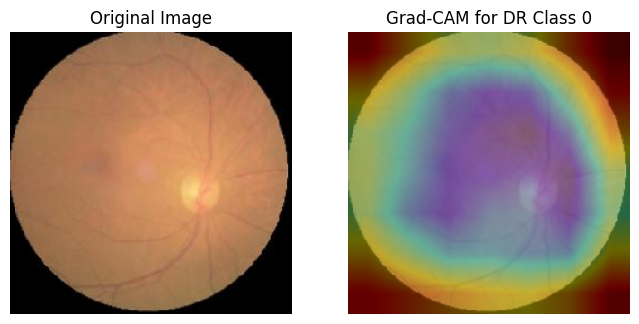

Prediction Results: {'cataract_probability': array([0.99810934], dtype=float32), 'glaucoma_probability': array([7.481068e-05], dtype=float32), 'dr_class': 0}


In [ ]:
results = preprocess_predict_and_visualize('/Users/priyankapalaniselvam/Downloads/RetinaNet/sample.jpg', new_model)
print("Prediction Results:", results)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


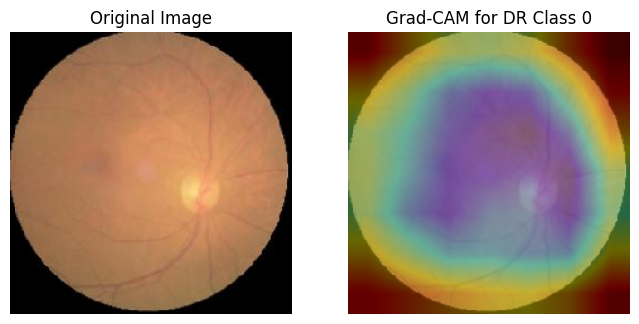

Prediction Results: {'cataract_probability': array([0.99810934], dtype=float32), 'glaucoma_probability': array([7.481068e-05], dtype=float32), 'dr_class': 0}


In [ ]:
results = preprocess_predict_and_visualize('/Users/priyankapalaniselvam/Downloads/RetinaNet/sample.jpg', new_model)
print("Prediction Results:", results)
